# 7 - Compasso de Ulisses

In [1]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd
from videpy import Vide

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import stan
import nest_asyncio

plt.style.use('default')

plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

### R Code 7.1 - Pag 194

In [3]:
sppnames = ('afarensis', 'africanus', 'habilis',  'boisei', 'rudolfensis', 'ergaster', 'sapiens')
brainvolcc = (438, 452, 612, 521,  752, 871, 1350)
masskg = (37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5)

d = pd.DataFrame({'species':sppnames, 'brain': brainvolcc, 'mass':masskg})
d

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


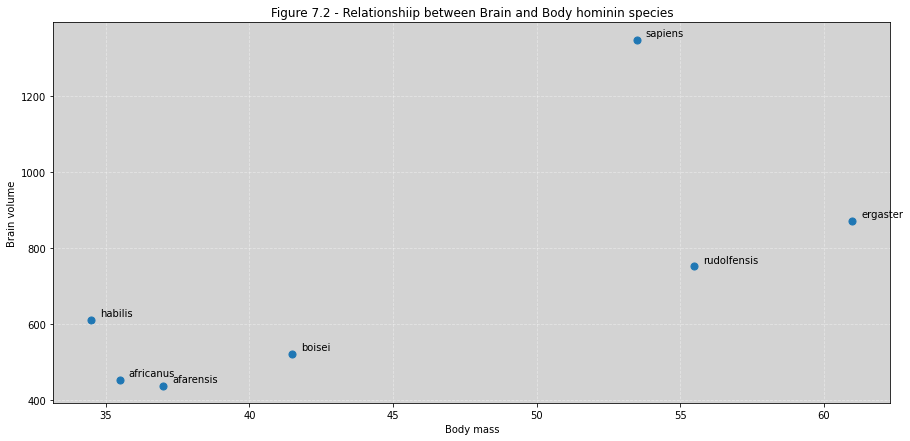

In [4]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(d.mass, d.brain, marker='o', s=50)

for i, text in enumerate(sppnames):
    ax.annotate(text, (d.mass[i]+0.3, d.brain[i]+10))
    
ax.set_title('Figure 7.2 - Relationshiip between Brain and Body hominin species')
ax.set_xlabel('Body mass')
ax.set_ylabel('Brain volume')

ax.grid(ls='--', color='white', alpha=0.4)
plt.show()

### R Code 7.2 - pag 196

In [5]:
np.std(d.mass, ddof=1)

10.90489186863706

In [6]:
d.mass.std()

10.90489186863706

In [7]:
d['mass_std'] = (d.mass - d.mass.mean())/d.mass.std()
d['brain_std'] = d.brain / np.max(d.brain)
d

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.779467,0.324444
1,africanus,452,35.5,-0.917020,0.334815
2,habilis,612,34.5,-1.008722,0.453333
3,boisei,521,41.5,-0.366808,0.385926
4,rudolfensis,752,55.5,0.917020,0.557037
5,ergaster,871,61.0,1.421380,0.645185
6,sapiens,1350,53.5,0.733616,1.000000


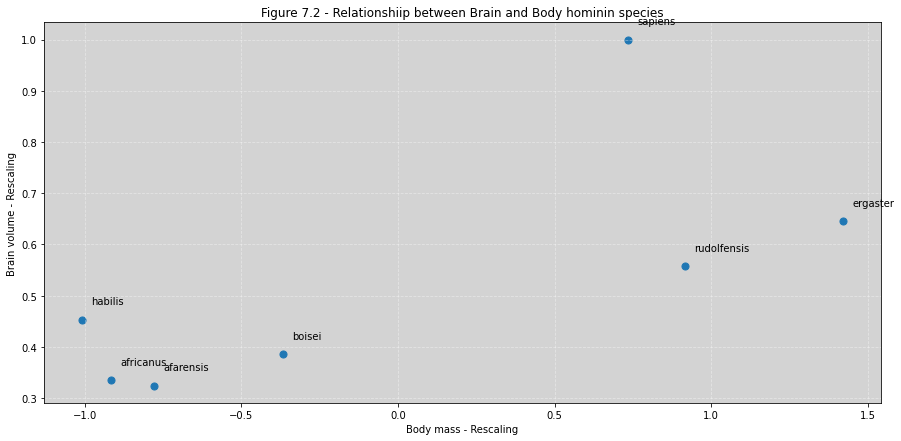

In [8]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(d.mass_std, d.brain_std, marker='o', s=50)

for i, text in enumerate(sppnames):
    ax.annotate(text, (d.mass_std[i]+0.03, d.brain_std[i]+0.03))
    
ax.set_title('Figure 7.2 - Relationshiip between Brain and Body hominin species')
ax.set_xlabel('Body mass - Rescaling')
ax.set_ylabel('Brain volume - Rescaling')

ax.grid(ls='--', color='white', alpha=0.4)
plt.show()

### R Code 7.3 - pag 196

Modelo linear:

$\begin{align}
b_i \sim Normal(\mu_i, \sigma) \\ 
\mu_i = \alpha + \beta m_i \\
\alpha \sim Normal(0.5, 1) \\
\beta \sim Normal(0, 10) \\
\sigma \sim LogNormal(0, 1) \\
\end{align}$





In [9]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
        // real log_sigma;  // Like the book
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta * body;
                
        // Prioris
        alpha ~ normal(0.5, 1);
        beta ~ normal(0, 10);
        sigma ~ lognormal(0, 1);
        // log_sigma ~ normal(0, 1);  // Like the book 
        
        // Likelihood
        brain ~ normal(mu, sigma);
        // brain ~ normal(mu, exp(sigma));  // Like the book
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_1 = stan.build(model, data=data)
samples_1 = posteriori_1.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.


Sampling:   0%


Sampling:  25% (2000/8000)


Sampling:  50% (4000/8000)


Sampling:  75% (6000/8000)


Sampling: 100% (8000/8000)


Sampling: 100% (8000/8000), done.


Messages received during sampling:


  Gradient evaluation took 3.6e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 3.4e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 3.8e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 3.8e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.


  Adjust your expectations accordingly!


In [10]:
Vide.summary(samples_1)

,mean,std,7.0%,93.0%
alpha,0.53,0.11,0.33,0.72
beta,0.17,0.12,-0.07,0.37
sigma,0.28,0.12,0.11,0.49


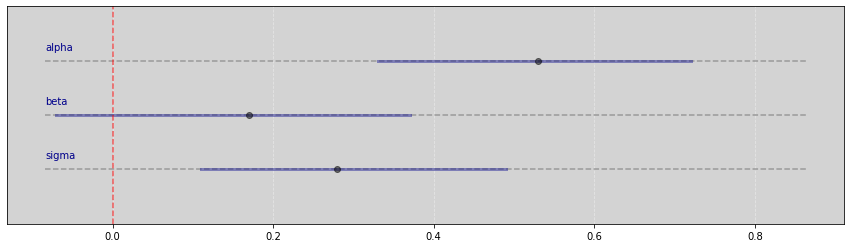

In [11]:
Vide.plot_forest(samples_1)

### R Code 7.4 - pag 196

Just example code in R

`m7.1_OLS <- lm(brain_std ~ brain_std, data=d)`

### R Code 7.5 - pag 197

In [12]:
def var2(x):
    return np.sum(np.power(x - np.mean(x), 2))/len(x)

In [13]:
mean_std = [np.mean((samples_1['alpha'].flatten() + samples_1['beta'].flatten() * mass)) for mass in d.mass_std.values]
r = mean_std - d.brain_std

resid_var = var2(r)
outcome_var = var2(d.brain_std)

1 - resid_var/outcome_var

0.490158020661996

### R Code 7.6 - Pag 197

In [14]:
def R2_is_bad():
    pass

### R Code 7.7 - pag 198

In [15]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[2];
        real<lower=0> sigma;
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta[1] * body + beta[2] * body^2;
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:2){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 1);    
        
        // Likelihood
        brain ~ normal(mu, sigma);
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_2 = stan.build(model, data=data)
samples_2 = posteriori_2.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.


Messages from stanc:


Warning in '/tmp/httpstan_fwxysar5/model_iv2oc3ez.stan', line 10, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


Sampling:   0%


Sampling:  25% (2000/8000)


Sampling:  50% (4000/8000)


Sampling:  75% (6000/8000)


Sampling: 100% (8000/8000)


Sampling: 100% (8000/8000), done.


Messages received during sampling:


  Gradient evaluation took 1.6e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 2.9e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 1.8e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 2.7e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.


  Adjust your expectations accordingly!


In [16]:
Vide.summary(samples_2)

,mean,std,7.0%,93.0%
alpha,0.61,0.24,0.18,1.04
beta[0],0.19,0.16,-0.08,0.48
beta[1],-0.10,0.24,-0.58,0.32
sigma,0.30,0.16,0.11,0.54


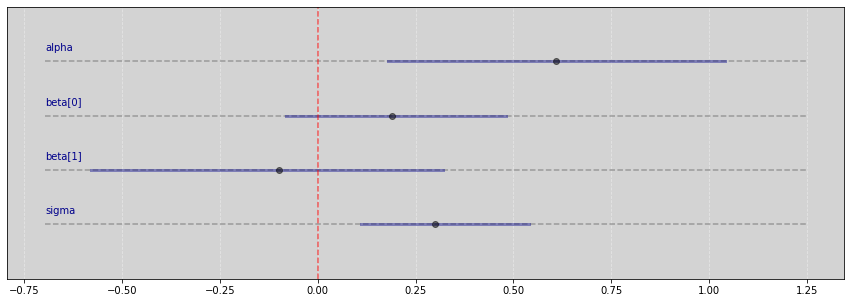

In [17]:
Vide.plot_forest(samples_2)

### R Code 7.8 - Pag 198

In [18]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[3];
        real<lower=0> sigma;
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3;
                     
        // Likelihood
        brain ~ normal(mu, sigma);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:3){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 1);    
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_3 = stan.build(model, data=data)
samples_3 = posteriori_3.sample(num_chains=4, num_samples=1000)

Error handling request
Traceback (most recent call last):
  File "/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/aiohttp/web_protocol.py", line 422, in _handle_request
    resp = await self._request_handler(request)
  File "/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/aiohttp/web_app.py", line 499, in _handle
    resp = await handler(request)
  File "/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/views.py", line 253, in handle_show_params
    services_module = httpstan.models.import_services_extension_module(model_name)
  File "/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/models.py", line 90, in import_services_extension_module
    module: ModuleType = importlib.util.module_from_spec(spec)  # type: ignore
  File "<frozen importlib._bootstrap>", line 556, in module_from_spec
  File "<frozen importlib._bootstrap_external>", line 1101, in create_module
  File "<frozen importlib._bootstrap

Error handling request
Traceback (most recent call last):
  File "/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/aiohttp/web_protocol.py", line 422, in _handle_request
    resp = await self._request_handler(request)
  File "/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/aiohttp/web_app.py", line 499, in _handle
    resp = await handler(request)
  File "/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/views.py", line 83, in handle_create_model
    httpstan.models.import_services_extension_module(model_name)
  File "/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/models.py", line 90, in import_services_extension_module
    module: ModuleType = importlib.util.module_from_spec(spec)  # type: ignore
  File "<frozen importlib._bootstrap>", line 556, in module_from_spec
  File "<frozen importlib._bootstrap_external>", line 1101, in create_module
  File "<frozen importlib._bootstrap>", line 219, in _

ValueError: The JSON document has an improper structure: missing or superfluous commas, braces, missing keys, etc.

In [19]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[4];
        real<lower=0> sigma;
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4;
                     
        // Likelihood
        brain ~ normal(mu, sigma);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:4){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 1);    
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_4 = stan.build(model, data=data)
samples_4 = posteriori_4.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_89iqtyto/model_5n3a3kju.stan', line 10, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:  10% (800/8000)
Sampling:  35% (2800/8000)
Sampling:  60% (4800/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 lea

In [20]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[5];
        real<lower=0> sigma;
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4 +
                     beta[5] * body^5;
                     
        // Likelihood
        brain ~ normal(mu, sigma);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:5){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 1);    
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_5 = stan.build(model, data=data)
samples_5 = posteriori_5.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_sc94oycl/model_3c7wjchh.stan', line 10, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  11% (900/8000)
Sampling:  16% (1300/8000)
Sampling:  39% (3100/8000)
Sampling:  60% (4800/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordin

### R Code 7.9 - Pag 199

In [21]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[6];
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4 +
                     beta[5] * body^5 +
                     beta[6] * body^6;
                     
        // Likelihood
        brain ~ normal(mu, 0.001);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:6){
            beta[j] ~ normal(0, 10);
        }    
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_6 = stan.build(model, data=data)
samples_6 = posteriori_6.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_bic3rat1/model_3skjj3wc.stan', line 10, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_bic3rat1/model_3skjj3wc.stan', line 24, column 27: Argument
    0.001 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   4% (300/8000)
Sampling:   6% (500/8000)
Sampling:  11% (900/8000)
Sampling:  18% (1400/8000)
Sampling:  20% (1600/8000)
Sampling:  22% (1800/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  35% (2800/8000)
Sampling:  38% (3000/8000)
Sampling:  54% (4300/8000)
Sampling:  71% (5700/8000)
Sampling:  

### R Code 7.10 - Pag 199

In [22]:
mass_seq = np.linspace(start=d.mass_std.min(), stop=d.mass_std.max(), num=100)

In [23]:
pp_1 = [samples_1['alpha'].flatten() + samples_1['beta'].flatten() * mass_i for mass_i in mass_seq]

In [24]:
pp_2 = [samples_2['alpha'].flatten() + 
        samples_2['beta'][0].flatten() * mass_i + 
        samples_2['beta'][1].flatten() * np.power(mass_i, 2) for mass_i in mass_seq]

In [25]:
pp_3 = [samples_3['alpha'].flatten() + 
        samples_3['beta'][0].flatten() * mass_i + 
        samples_3['beta'][1].flatten() * np.power(mass_i, 2) + 
        samples_3['beta'][2].flatten() * np.power(mass_i, 3)
        for mass_i in mass_seq]

In [26]:
pp_4 = [samples_4['alpha'].flatten() + 
        samples_4['beta'][0].flatten() * mass_i + 
        samples_4['beta'][1].flatten() * np.power(mass_i, 2) + 
        samples_4['beta'][2].flatten() * np.power(mass_i, 3) +
        samples_4['beta'][3].flatten() * np.power(mass_i, 4) 
        for mass_i in mass_seq]

In [27]:
pp_5 = [samples_5['alpha'].flatten() + 
        samples_5['beta'][0].flatten() * mass_i + 
        samples_5['beta'][1].flatten() * np.power(mass_i, 2) + 
        samples_5['beta'][2].flatten() * np.power(mass_i, 3) +
        samples_5['beta'][3].flatten() * np.power(mass_i, 4) + 
        samples_5['beta'][4].flatten() * np.power(mass_i, 5) 
        for mass_i in mass_seq]

In [28]:
pp_6 = [samples_6['alpha'].flatten() + 
        samples_6['beta'][0].flatten() * mass_i + 
        samples_6['beta'][1].flatten() * np.power(mass_i, 2) + 
        samples_6['beta'][2].flatten() * np.power(mass_i, 3) +
        samples_6['beta'][3].flatten() * np.power(mass_i, 4) + 
        samples_6['beta'][4].flatten() * np.power(mass_i, 5) + 
        samples_6['beta'][5].flatten() * np.power(mass_i, 6) 
        for mass_i in mass_seq]

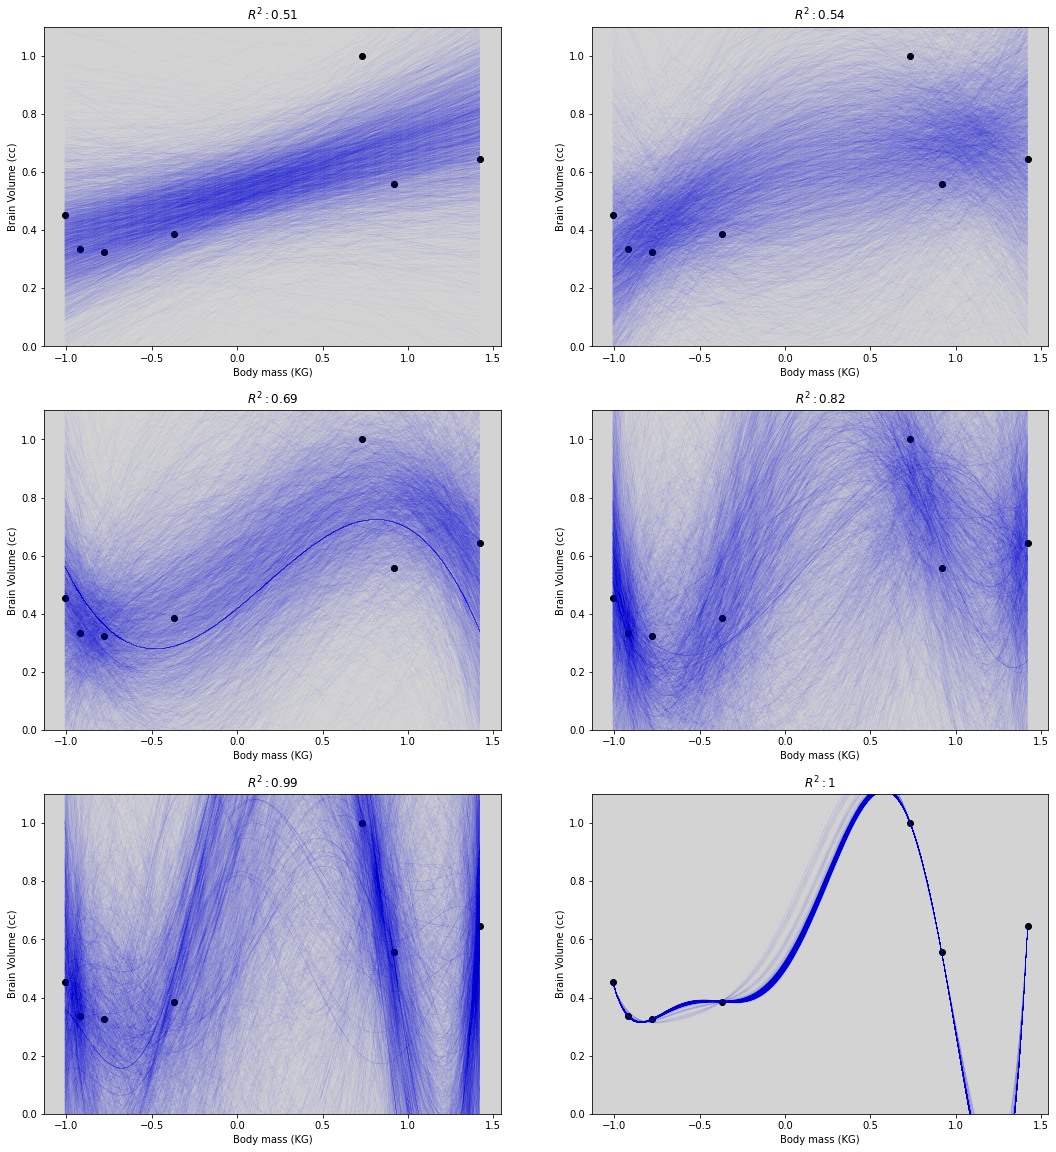

In [29]:
fig = plt.figure(figsize=(18, 20))

gs = GridSpec(nrows=3, ncols=2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax1.plot(mass_seq, pp_1, c='blue', lw=0.01)
ax1.set_ylim(0, 1.1)
ax1.set_title('$R^2: 0.51$')
ax1.set_xlabel('Body mass (KG)')
ax1.set_ylabel('Brain Volume (cc)')

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax2.plot(mass_seq, pp_2, c='blue', lw=0.01)
ax2.set_ylim(0, 1.1)
ax2.set_title('$R^2: 0.54$')
ax2.set_xlabel('Body mass (KG)')
ax2.set_ylabel('Brain Volume (cc)')

ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax3.plot(mass_seq, pp_3, c='blue', lw=0.01)
ax3.set_ylim(0, 1.1)
ax3.set_title('$R^2: 0.69$')
ax3.set_xlabel('Body mass (KG)')
ax3.set_ylabel('Brain Volume (cc)')

ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax4.plot(mass_seq, pp_4, c='blue', lw=0.01)
ax4.set_ylim(0, 1.1)
ax4.set_title('$R^2: 0.82$')
ax4.set_xlabel('Body mass (KG)')
ax4.set_ylabel('Brain Volume (cc)')

ax5 = fig.add_subplot(gs[2, 0])
ax5.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax5.plot(mass_seq, pp_5, c='blue', lw=0.01)
ax5.set_ylim(0, 1.1)
ax5.set_title('$R^2: 0.99$')
ax5.set_xlabel('Body mass (KG)')
ax5.set_ylabel('Brain Volume (cc)')

ax6 = fig.add_subplot(gs[2, 1])
ax6.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax6.plot(mass_seq, pp_6, c='blue', lw=0.01)
ax6.set_ylim(0, 1.1)
ax6.set_title('$R^2: 1$')
ax6.set_xlabel('Body mass (KG)')
ax6.set_ylabel('Brain Volume (cc)')

plt.show()

### R Code 7.11 - Pag 201

In [30]:
d.brain_std

0    0.324444
1    0.334815
2    0.453333
3    0.385926
4    0.557037
5    0.645185
6    1.000000
Name: brain_std, dtype: float64

Deletando a linha $i=3$ do dataframe:

In [31]:
d_deleted_line_3 = d.brain_std.drop(3)
d_deleted_line_3

0    0.324444
1    0.334815
2    0.453333
4    0.557037
5    0.645185
6    1.000000
Name: brain_std, dtype: float64

### R Code 7.12 - Pag 206

**Entropia da informação**:  *A incerteza contida na distribuição de probabilidade* é a média do $log$ da probabilidade do evento.

In [32]:
def H(p):
    """Information Entropy
    H(p):= -sum(p_i * log(pi))
    """
    if not np.sum(p) == 1:
        print('ProbabilityError: This is not probability, its sum not equal to 1.')
    else:
        return - np.sum([p_i * np.log(p_i) if p_i > 0 else 0 for p_i in p])

In [33]:
p = (0.3, 0.7)  # (p_rain, p_sum)

H(p)

0.6108643020548935

A incerteza do clima de *Abu Dhabi* é menor, pois é pouco provável que chova.

In [34]:
p_AbuDhabi = (0.01, 0.99)  # (p_rain, p_sum)

H(p_AbuDhabi)

0.056001534354847345

In [35]:
p_3dim = (0.7, 0.15, 0.15)  # (p_1, p_2, p_3)

H(p_3dim)

0.818808456222877

### R Code 7.13 - pag 210

References:  

- https://stackoverflow.com/questions/49147905/how-to-extract-posterior-samples-of-log-likelihood-from-pystan

- https://mc-stan.org/docs/2_20/functions-reference/normal-distribution.html

**Obs**:

Here I learned to use the two blocks in stan: *transformed parameters* and *generated quantities*.

To calculate the **Deviance** it is necessary to make these changes. 

That's why I did all 6 estimates again with the calculations needed.

In [36]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        mu = alpha + beta * body;
    }
    
    model {
        // Prioris
        alpha ~ normal(0.5, 1);
        beta ~ normal(0, 10);
        sigma ~ lognormal(0, 1);    
        
        // Likelihood
        brain ~ normal(mu, sigma);
    }
    
    generated quantities {
        vector[N] log_lik;
        vector[N] brain_hat;
        
        for (i in 1:N){
            log_lik[i] = normal_lpdf(brain[i] | mu[i], sigma);
            brain_hat[i] = normal_rng(mu[i], sigma);
        }
        
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_1 = stan.build(model, data=data)
samples_1 = posteriori_1.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!


In [37]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[2];
        real<lower=0> sigma;
    }
    
    transformed parameters{
        vector[N] mu;
        mu = alpha + beta[1] * body + 
                     beta[2] * body^2;
    }
    
    model {
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:2){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 10);    
        
        // Likelihood
        brain ~ normal(mu, sigma);
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_2 = stan.build(model, data=data)
samples_2 = posteriori_2.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_r8ixtt9p/model_szw6dlh7.stan', line 10, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition

In [38]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[3];
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3;
    }
    
    model {                     
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:3){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 10);   
        
        // Likelihood
        brain ~ normal(mu, sigma);
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_3 = stan.build(model, data=data)
samples_3 = posteriori_3.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_1ipahraa/model_a6y4smla.stan', line 10, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition wo

In [39]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[4];
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4;
    }
    
    model {
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:4){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 10); 
        
        // Likelihood
        brain ~ normal(mu, sigma);   
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_4 = stan.build(model, data=data)
samples_4 = posteriori_4.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_y03vqbot/model_5q3b5yyn.stan', line 10, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   9% (700/8000)
Sampling:  34% (2700/8000)
Sampling:  59% (4700/8000)
Sampling:  84% (6700/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 lea

In [40]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[5];
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4 +
                     beta[5] * body^5;
    }
    
    model {          
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:5){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 10);    
        
        // Likelihood
        brain ~ normal(mu, sigma);
    }
    
    generated quantities {
        vector[N] log_lik;
        vector[N] brain_hat;
        
        for (i in 1:N){
            log_lik[i] = normal_lpdf(brain[i] | mu[i], sigma);
            brain_hat[i] = normal_rng(mu[i], sigma);
        }
        
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_5 = stan.build(model, data=data)
samples_5 = posteriori_5.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_23fy4d7r/model_4rwldby2.stan', line 10, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   4% (300/8000)
Sampling:   9% (700/8000)
Sampling:  12% (1000/8000)
Sampling:  21% (1700/8000)
Sampling:  44% (3500/8000)
Sampling:  64% (5100/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust

In [41]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[6];
    }
    
    transformed parameters {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4 +
                     beta[5] * body^5 +
                     beta[6] * body^6;
    }
    
    model {          
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:6){
            beta[j] ~ normal(0, 10);
        }    
        
        // Likelihood
        brain ~ normal(mu, 0.001);
    }
    
    generated quantities {
        vector[N] log_ll_y;
        
        for (i in 1:N){
            log_ll_y[i] = normal_lpdf(brain[i] | mu, 0.001);
        }
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_6 = stan.build(model, data=data)
samples_6 = posteriori_6.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_17n24ee8/model_exxiy3jy.stan', line 10, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_17n24ee8/model_exxiy3jy.stan', line 32, column 27: Argument
    0.001 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   4% (300/8000)
Sampling:   6% (500/8000)
Sampling:  11% (900/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  35% (2800/8000)
Sampling:  38% (3000/8000)
Sampling:  54% (4300/8000)
Sampling:  71% (5700/8000)
Sampling:  

In [42]:
def lppd(samples, outcome, std_residuals=True):
    """ Calculate the LOG-POINTWISE-PREDICTIVE-DENSITY
    
    samples : stan
        Sampler results of fit posteriori. 
        Need 'mu' already computed.
    
    outcome : list
        List with outcomes the original data.
        
    std_residuals : booleans
        Compute lppd using std of the residuals 
    """
    mu = samples['mu']
    N = len(outcome)
    K = np.shape(mu)[1]  # Qty samples (mu) sampled from posteriori

    outcome = outcome.reshape(-1, 1)

    if std_residuals:
        sigma = (np.sum((mu - outcome)**2, 0) / N)**0.5    
    else:
        sigma = samples['sigma'].flatten()
        
    lppd = np.empty(N, dtype=float)
       
    for i in range(N):
        log_posteriori_predictive = stats.norm.logpdf(outcome[i], mu[i], sigma)

        lppd[i] = np.log(np.sum(np.exp(log_posteriori_predictive))) - np.log(K)
    
    return lppd    

### R Code 7.15

Like the book and the [this](https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_07.ipynb) one the values here have slight differeces. 

*Need review calculations - pag 211 - 2ed*

In [43]:
lppd_lm = []

lppd_lm.append(np.sum(lppd(samples_1, d.brain_std.values, std_residuals=True)))
lppd_lm.append(np.sum(lppd(samples_2, d.brain_std.values, std_residuals=True)))
lppd_lm.append(np.sum(lppd(samples_3, d.brain_std.values, std_residuals=True)))
lppd_lm.append(np.sum(lppd(samples_4, d.brain_std.values, std_residuals=True)))
lppd_lm.append(np.sum(lppd(samples_5, d.brain_std.values, std_residuals=True)))
lppd_lm.append(np.sum(lppd(samples_6, d.brain_std.values, std_residuals=True)))

lppd_lm

[1.9566327201814353,
 1.941588551424057,
 2.14378226869432,
 2.754228507821768,
 5.480033073131333,
 40.03033955975213]

In [44]:
import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

In [45]:
data = az.from_pystan(
    posterior=samples_5,
    posterior_predictive="brain_hat",
    observed_data=data,
    log_likelihood={"brain": "log_lik"},
)

data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats

In [46]:
data5 = az.from_pystan(
    posterior=samples_5,
    posterior_predictive="brain_hat",
    observed_data=data,
    log_likelihood={"brain": "log_lik"},
)

data5

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats

In [47]:
y_true = d.brain_std.values
y_pred = data5.posterior_predictive.stack(sample=("chain", "draw"))["brain_hat"].values.T
az.r2_score(y_true, y_pred)

r2        0.672509
r2_std    0.166309
dtype: float64

In [48]:
aa = az.loo(samples_5, pointwise=True)

/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


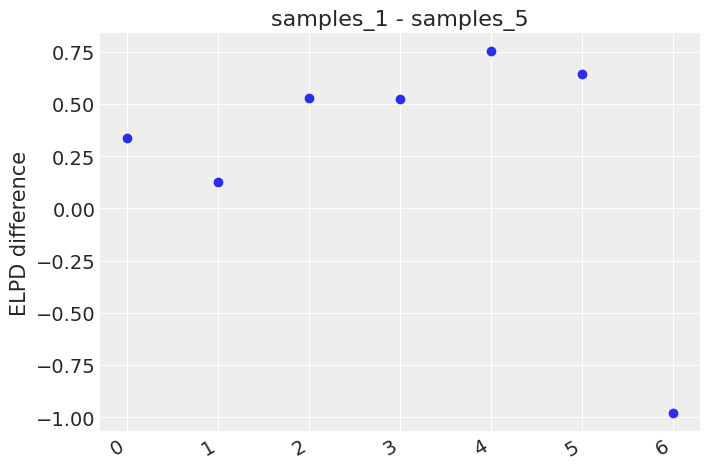

In [51]:
az.plot_elpd({'samples_1':samples_1, 'samples_5': samples_5}, xlabels=True)
plt.show()

In [50]:
aaa = data.posterior_predictive.brain_hat[0].values
np.log(np.sum(np.exp(aaa.T), 1)) - np.log(1000)

array([0.50019162, 0.61303674, 0.6133973 , 0.44845226, 0.79786415,
       2.0166922 , 7.29542366])

### R Code 7.16

Just using Rethinking Packages - pag 213

### R Code 7.17

Just using Rethinking Packages - Pag 213

### R Code 7.18

Just using Rethinking Packages - pag 214

-------